In [ ]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import splitfolders

In [ ]:
# Put my dataset into input_folder variable to split it into train, validation and test
# Reference: https://www.youtube.com/watch?v=C6wbr1jJvVs

input_folder = 'Dataset (CT Scans by Plameneduardo)'

In [ ]:
# Split the dataset based on ratio
# 0.7 for train, 0.2 for validation and 0.1 for test
# Training data is used to train and update the weight
# Validation data is used as a part of the training but 
# only to validate after each epochs and metrics
# Testing data never get use in the training
# It is something we use after the training is fully completed to test the completed train model
# Ideally the test data should come from somewhere else but in this case we split it 

splitfolders.ratio(input_folder, output='Split Dataset (CT Scans by Plameneduardo)',
                   seed=814, ratio=(0.7, 0.2, 0.1),
                   group_prefix=None)

Copying files: 2481 files [00:07, 323.27 files/s]


In [ ]:
pip install seaborn

In [ ]:
pip install tensorflow

In [ ]:
pip install opencv-python

In [ ]:
# Importing the required libraries

import keras
import tensorflow
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications.resnet import ResNet50
from tensorflow.keras.utils import plot_model

In [ ]:
# Check the version for Keras

keras.__version__

'2.8.0'

In [ ]:
# This is to load the pre trained resnet model
# In this model, the top layers known as dense layers before output will be freezed
# Imagenet will be used as weights
# Since the include_top = False hence the pooling can be optional
# Pooling will set as None because it is not required
# The input shape will be 224x224 with 3 RGB as mentioned in the assignment

resnet50 = ResNet50(include_top=False, weights='imagenet',
              input_shape=(224, 224, 3),
              pooling=None)

In [ ]:
# Classification layers that can be customized will be added

from tensorflow.keras import optimizers

# Execute sequential model and adopt ResNet50 model

model = keras.models.Sequential()

# On top the VGG16 model, custom layers will be added:
# Pooling layers will be included in the first 5 layers to reduce the dimensions of the feature maps
# Reference: https://github.com/vaibhavcodes/DeepLearning-Architectures/blob/master/03_VGG_16_Architecture.ipynb

# Develop the first block with 2 Convolution and 1 Max pool
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',
          input_shape=(224, 224, 3), activation='relu'))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same',
          activation='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Develop the second block with 2 Convolution and 1 Max pool
model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same',
          activation='relu'))

model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same',
          activation='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

#Develop the third block with 3 Convolutional and 1 Max pool
model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding='same',
          activation='relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same',
          activation='relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same',
          activation='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

#Develop the fourth block with 3 Convolutional and 1 Max pool
model.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same',
          activation='relu'))

model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same',
          activation='relu'))

model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same',
          activation='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

#Develop the fifth block with 3 Convolutional and 1 Max pool
model.add(Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), padding='same',
          activation='relu'))

model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same',
          activation='relu'))

model.add(Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same',
          activation='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

# Add a flatten layer after done developing the convolutional layers
# Flatten layer is basically flatten the multi-dimensional input tensors into a single dimension
# In layman term, eg: a 3x3 matrix will be flatten to a 1 long column for better further processing in the model
model.add(Flatten())

# Develop 3 Dense layers (2 for normal and 1 for output)
# First 2 Dense layers
model.add(Dense(units=4096, activation='relu'))
model.add(Dense(units=4096, activation='relu'))

# Add a dropout layer with 0.5 rate
model.add(Dropout(0.5))

# The last Dense layer for output
# In here the neurons will be 1 because this dataset only has 2 categories which are COVID and non-COVID, hence 1 is fine
# If use 2, it will caused error during model.fit() process
# Activation will be using softmax because softmax is suitable for classification while linear suitable for regression 
# Reference: https://stats.stackexchange.com/questions/218542/which-activation-function-for-output-layer
model.add(Dense(units=1, activation='softmax'))

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [ ]:
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
# Have an in-depth look in the model architecture of ResNet50

base_model = ResNet50(weights='imagenet', include_top = False)
base_model.summary()
plot_model(base_model)

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

Data Preparation

In [ ]:
# Provide path to the dataset
base_ds = r'C:\Split Dataset (CT Scans by Plameneduardo)' # Your own system path after splitted
train_ds = os.path.join(base_ds, 'train')
validation_ds = os.path.join(base_ds, 'val')
test_ds = os.path.join(base_ds, 'test')

In [ ]:
# Check the path for each datasets
train_ds

In [ ]:
# Check the path for each datasets
validation_ds

In [ ]:
# Check the path for each datasets
test_ds

In [ ]:
# Apply directories for the purpose in the training
# Combines path names into one complete path
# Various part of paths can be merged into one

# Directory with our training COVID pictures
train_covid_ds = os.path.join(train_ds, 'COVID')
# Directory with our training non-COVID pictures
train_non_COVID_ds = os.path.join(train_ds, 'non-COVID')

# Directory with our validation COVID pictures
validation_covid_ds = os.path.join(validation_ds, 'COVID')
# Directory with our validation non-COVID pictures
validation_non_COVID_ds = os.path.join(validation_ds, 'non-COVID')

# Directory with our validation COVID pictures
test_covid_ds = os.path.join(test_ds, 'COVID')
# Directory with our validation non-COVID pictures
test_non_COVID_ds = os.path.join(test_ds, 'non-COVID')

In [ ]:
# Check the directory on one of the dataset to confirm it has no error

train_covid_ds

In [ ]:
# Check the quantity of the covid images in train_covid_ds

print('total training covid images:', len(os.listdir(train_covid_ds)))

total training covid images: 876


In [ ]:
# Preparing the data
# Batch size depends on the datset size. 
# In this example there are 1736 image in training set and 495 in test set.
# The factor numbers for both are different hence it is hard to choose batch size
# The easy solution is set the batch size to 1 and it can run smoothly in the later part
# Have tried different numbers but during training the modelm it keep interrupted due to lack of data
# Suggested to use repeat() function but this dataset is not contructed by code hence repeat() is not advisable

from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory (train_ds, )
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_ds,
        # All images will be resized to 224x224
        target_size=(224, 224),
        batch_size=1,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_ds,
        target_size=(224, 224),
        batch_size=1,
        class_mode='binary')

Found 1736 images belonging to 2 classes.
Found 1736 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


In [ ]:
# To see the batch shape of data
# It shows 1 due to batch size with 224x224x3
# Labels batch shape is 1 as well due to the batch size in previous cell

for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (1, 224, 224, 3)
labels batch shape: (1,)


In [ ]:
# Develop and add early stopping to the model training

from keras.callbacks import EarlyStopping

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                               min_delta=0, verbose=2, mode='auto',
                                               restore_best_weights=True,
                                               )

In [ ]:
# steps_per_epoch is based on the number of batches available in the training dataset
# validation_steps is based on the number of batches in the validation dataset
# Because train and valid datasets only got 2231, hence use 97 and 23

history = model.fit(
      train_generator,
      steps_per_epoch=97,
      epochs=23,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[early_stopping])

Epoch 1/23
97/97 [==============================] - 133s 1s/step - loss: 0.7813 - accuracy: 0.4639 - val_loss: 0.7356 - val_accuracy: 0.4800
Epoch 2/23
97/97 [==============================] - 128s 1s/step - loss: 0.7462 - accuracy: 0.5258 - val_loss: 0.6888 - val_accuracy: 0.4400
Epoch 3/23
97/97 [==============================] - 125s 1s/step - loss: 0.7285 - accuracy: 0.4536 - val_loss: 0.7049 - val_accuracy: 0.4800
Epoch 4/23
97/97 [==============================] - 126s 1s/step - loss: 0.7412 - accuracy: 0.5361 - val_loss: 0.6859 - val_accuracy: 0.4400
Epoch 5/23
97/97 [==============================] - 125s 1s/step - loss: 0.7410 - accuracy: 0.4742 - val_loss: 0.7766 - val_accuracy: 0.5600
Epoch 6/23
97/97 [==============================] - 125s 1s/step - loss: 0.7527 - accuracy: 0.4227 - val_loss: 0.6940 - val_accuracy: 0.4800
Epoch 7/23
97/97 [==============================] - 125s 1s/step - loss: 0.7347 - accuracy: 0.4742 - val_loss: 0.7262 - val_accuracy: 0.6000
Epoch 8/23
97

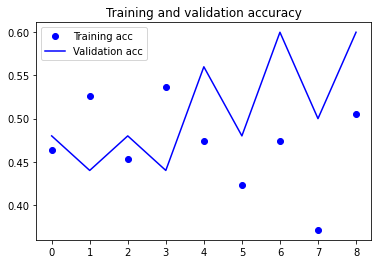

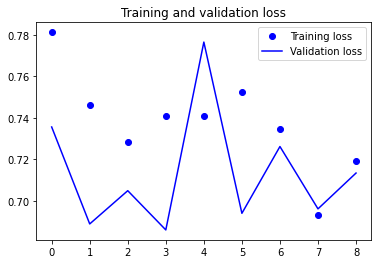

In [ ]:
# Show the training and validation accuracy through visualization (plot model)
# Show the training and validation loss through visualization (plot model)

import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

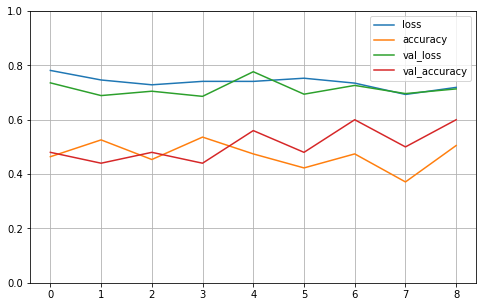

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()